## Summary

Kaparthy implementation of RNN, following Mikolov et al. 2010: https://youtu.be/P6sfmUTpUmc?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ

**Introduction**

The lecture continues the implementation of a character-level language model called "makemore." The focus shifts from a multi-layer perceptron (MLP) to more complex neural networks, specifically recurrent neural networks (RNNs) and their variants like GRUs and LSTMs. The instructor emphasizes the importance of understanding the activations and gradients in neural networks to optimize them effectively.


**Initial Setup:** The lecture begins with a recap of the previous implementation, where an MLP was used to predict the next character in a sequence. The code has been cleaned up for better readability, removing "magic numbers" and structuring it more intuitively.

**Loss Function:** The initial loss recorded during training is excessively high (27), indicating issues with network initialization. The expected loss at initialization should be around 3.29, assuming a uniform probability distribution over the characters.

**Logits and Initialization:** The instructor discusses how logits (the raw outputs of the network before applying the softmax function) should ideally be close to zero at initialization. High initial logits lead to high loss due to the network being "confidently wrong."

**Adjustments to Improve Initialization:** To achieve better initialization, the instructor suggests setting the bias term to zero and scaling down the weight matrix. This helps bring logits closer to the expected values.

**Gradient Flow Issues:** The lecture highlights a deeper problem with the hidden state activations (H) of the network. Many values are being squashed to extreme values (-1 or 1) due to the hyperbolic tangent (tanh) activation function, which can hinder effective backpropagation.

**Impact on Backpropagation:** The instructor explains that when the outputs of the tanh function are close to -1 or 1, the gradients can vanish during backpropagation, effectively stopping learning. This is a critical issue that needs to be addressed for effective training.

**Visualizing Activations:** The instructor demonstrates how to visualize the distribution of activations and pre-activations to diagnose issues in the network.

**Final Thoughts:** The lecture concludes with a focus on the importance of initialization and understanding the behavior of gradients in neural networks to improve training efficiency and effectiveness.
Overall, the lecture provides insights into the challenges of training neural networks, particularly RNNs, and emphasizes the significance of proper initialization and gradient flow for successful optimization.



**Reference:**

Kaparthy implementation of RNN, following Mikolov et al. 2010: https://youtu.be/P6sfmUTpUmc?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ

https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf

We dive into some of the internals of MLPs with multiple layers and scrutinize the statistics of the forward pass activations, backward pass gradients, and some of the pitfalls when they are improperly scaled. We also look at the typical diagnostic tools and visualizations you'd want to use to understand the health of your deep network. We learn why training deep neural nets can be fragile and introduce the first modern innovation that made doing so much easier: Batch Normalization. Residual connections and the Adam optimizer remain notable todos for later video.

Links:
- makemore on github: https://github.com/karpathy/makemore 
- jupyter notebook I built in this video: https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part3_bn.ipynb
- collab notebook: https://colab.research.google.com/drive/1H5CSy-OnisagUgDUXhHwo1ng2pjKHYSN?usp=sharing
- my website: https://karpathy.ai
- my twitter:   / karpathy  
- Discord channel:   / discord  

Useful links:
- "Kaiming init" paper: https://arxiv.org/abs/1502.01852
- BatchNorm paper: https://arxiv.org/abs/1502.03167
- Bengio et al. 2003 MLP language model paper (pdf): https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
- Good paper illustrating some of the problems with batchnorm in practice: https://arxiv.org/abs/2105.07576
- https://pytorch.org/docs/stable/nn.init.html
- https://github.com/pytorch/vision/blob/6db1569c89094cf23f3bc41f79275c45e9fcb3f3/torchvision/models/resnet.py#L124
- https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
- https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d


Exercises:
- E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.
- E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

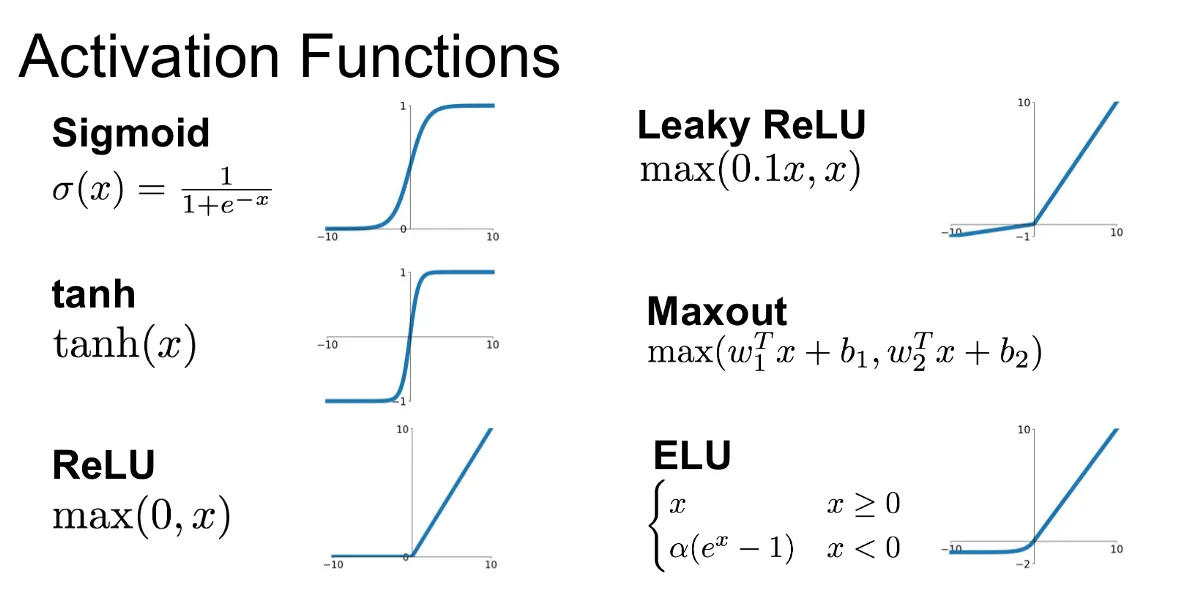

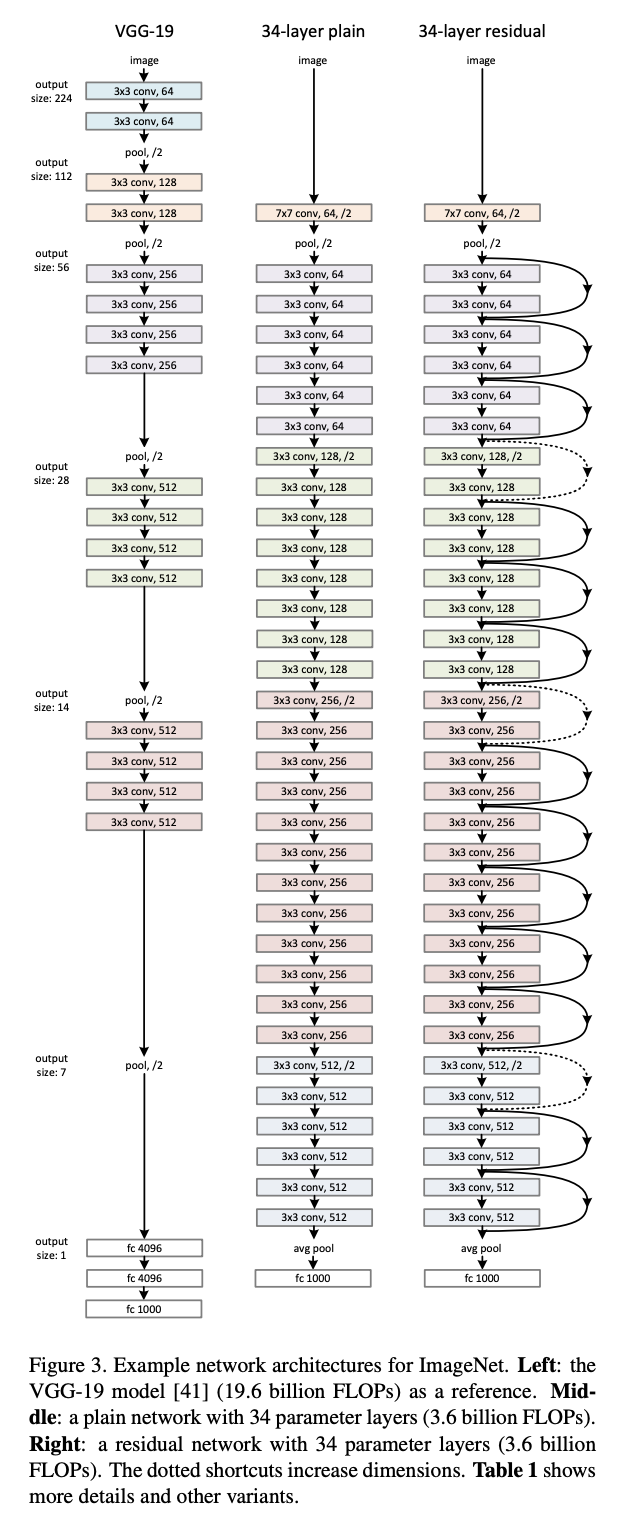

In [447]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [448]:
# ------------------- #
# read the raw data
words = open('data/names.txt', 'r').read().splitlines()
# ------------------- #

In [449]:
# ------------------- #
# build the vocab of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)
# ------------------- #

In [450]:
block_size = 3           # number of previous characters
def build_dataset(words, block_size):
    # build the dataset
    X, Y, = [], []                       # do we take to predict the next one
    for w in words:                      # inputs and labels to the neural net.
        context = [0] * block_size
    
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
    
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [451]:
# ------------------- # 
# initialize (MLP revised)
# ------------------- #
n_embd = 10                                                                                       # the dimensionality of the character embedding vectors. fan_in
n_hidden = 200                                                                                    # the number of of neurons in the hidden layer of the MLP.
vocab_size = len(stoi)                                                                            # number of characters
g = torch.Generator().manual_seed(2147483647)                                                     # for reproducibility.
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # https://pytorch.org/docs/stable/nn.init.html#:~:text=The%20values%20are%20as%20follows%3A
#b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01                               # to avoid high initialization
b2 = torch.randn(vocab_size,                    generator=g) * 0                                  # to avoid high initialization
eps = torch.finfo(torch.float32).eps


# batchnorm parameters
bngain = torch.ones((1, n_hidden))  # batch normalization gains; https://arxiv.org/pdf/1502.03167
bnbias = torch.zeros((1, n_hidden)) # batch normalization bias
bnmean_running = torch.zeros((1, n_hidden))  # running batch mean
bnstd_running = torch.ones((1, n_hidden))    # running batch std

parameters = [C, W1, b1, W2, b2, bngain, bnbias]                                                                  # group parameters in a list. 
parameters = [C, W1, W2, b2, bngain, bnbias]                                                                  # group parameters in a list. 
print(sum(p.nelement() for p in parameters))                                                      # number of parameters in total 

for p in parameters:                                                                              # calculate gradients for parameters
    p.requires_grad = True

12097


In [452]:
fan_in = n_embd * block_size # for W1
(5/3)/(fan_in)**0.5  # https://pytorch.org/docs/stable/nn.init.html#:~:text=The%20values%20are%20as%20follows%3A

0.3042903097250923

tensor(0.0009) tensor(0.9960)
tensor(-0.0006) tensor(0.9966)


(array([4.36847401e-05, 4.36847401e-05, 8.73694802e-05, 1.09211850e-04,
        1.74738960e-04, 3.05793181e-04, 4.15005031e-04, 6.33428732e-04,
        1.46343879e-03, 1.96581330e-03, 3.18898603e-03, 5.37322303e-03,
        9.02089883e-03, 1.41538558e-02, 2.28689614e-02, 3.66296546e-02,
        5.43875014e-02, 8.26952130e-02, 1.19215656e-01, 1.62485391e-01,
        2.18838706e-01, 2.83426594e-01, 3.49761872e-01, 3.95936642e-01,
        4.28590985e-01, 4.25969901e-01, 3.94604257e-01, 3.46354462e-01,
        2.83011589e-01, 2.21481632e-01, 1.61196691e-01, 1.17490109e-01,
        7.74967289e-02, 5.49554031e-02, 3.55812208e-02, 2.29563309e-02,
        1.42193829e-02, 7.81956848e-03, 5.54796199e-03, 3.07977418e-03,
        1.85660145e-03, 1.09211850e-03, 7.64482952e-04, 5.89743991e-04,
        1.96581330e-04, 1.09211850e-04, 1.09211850e-04, 8.73694802e-05,
        4.36847401e-05, 4.36847401e-05]),
 array([-5.71915531e+00, -5.49024242e+00, -5.26132954e+00, -5.03241665e+00,
        -4.8035037

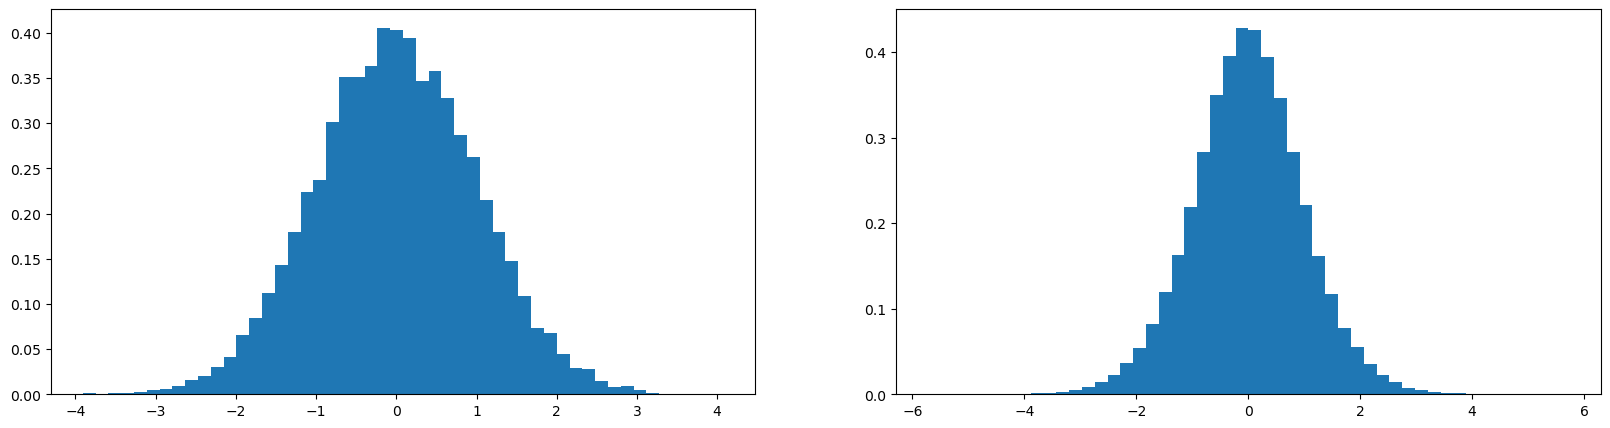

In [453]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

In [454]:
hpreact.mean(0, keepdim=True).shape # keepdim=True to easily broad cast it

torch.Size([1, 200])

In [455]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


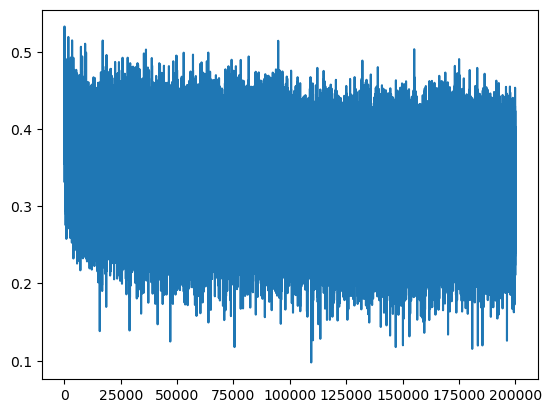

In [456]:
# same optimization we did in part 2
max_steps = 200000
batch_size = 32
lossi = []

for step in range(max_steps):
    
    # minibatch batch construct
    # ----------------------------------------------------------------------
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]            # batch X, Y
    
    # forward pass
    # ----------------------------------------------------------------------
    emb = C[Xb]                          # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concat. the vectors
    
    # linear layer
    # ----------------------------------------------------------------------
    hpreact = embcat @ W1 #+ b1           # hidden layer pre-activation
    
    # batchnorm layer
    # ----------------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / (bnstdi) + bnbias
    with torch.no_grad():            
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi 
    
    # ----------------------------------------------------------------------
    # non-linearity
    h = torch.tanh(hpreact)              # hidden layer
    logits = h @ W2 + b2                 # output layer
    loss = F.cross_entropy(logits, Yb)   # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    # lr = lrs[step]
    lr = 0.1 if step < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if step % 10000 == 0: # print every once in a while
        print(f'{step:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
plt.plot(lossi)

In [457]:
# plt.hist(h.view(-1).tolist(), 50);
# plt.figure(figsize=(20,10))
# plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [458]:
# plt.hist(hpreact.view(-1).tolist(), 50);

In [459]:
# exptected_loss = -torch.tensor(1/27.0).log()

In [460]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [461]:
@torch.no_grad() # decorator to disable gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    
    hpreact = embcat @ W1 + b1           # hidden layer pre-activation
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias

    h = torch.tanh(hpreact)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 2.0674192905426025
val 2.105670690536499


In [470]:
# ------------------- #
# sample from the model
# ------------------- #
g = torch.Generator().manual_seed(2147483647 + 10)  # for reproducibility
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all dots
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]                                                 
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)                  
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        # if we sample the special '.' token, breal
        if ix == 0:
            break
    print(''.join(out))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x60 and 30x200)

In [463]:
# Let's train deeper network
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers (trained with a running 'moomentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)                 # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True)    # batch variance
        else:
            x.mean = self.running_mean
            x.var = self.running_var
        xhat = (x - xmean ) / (torch.sqrt(xvar + self.eps)) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
        
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [471]:
# initialize
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),        generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden),   BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden),   BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden),   BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden),   BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden),   BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, vocab_size),   BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    # layers[-1].weight *= 0.1 # commented out because last leyer is BatchNorm1d, insted we update gama!
    layers[-1].gamma *= 0.1
    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters: 
    p.requires_grad = True

47551


In [472]:
# same optimization we did in part 2
max_steps = 200000
batch_size = 32
lossi = []
ud = []
for step in range(max_steps):
    
    # minibatch batch construct
    # ----------------------------------------------------------------------
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]            # batch X, Y
    
    # forward pass
    # ----------------------------------------------------------------------
    emb = C[Xb]                          # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)       # concat the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)        # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # update
    lr = 0.1 if step < 100000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if step % 10000 == 0: # print every once in a while
        print(f'{step:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if step >= 1000:
        break # AFTER_DEBUG: would take out

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

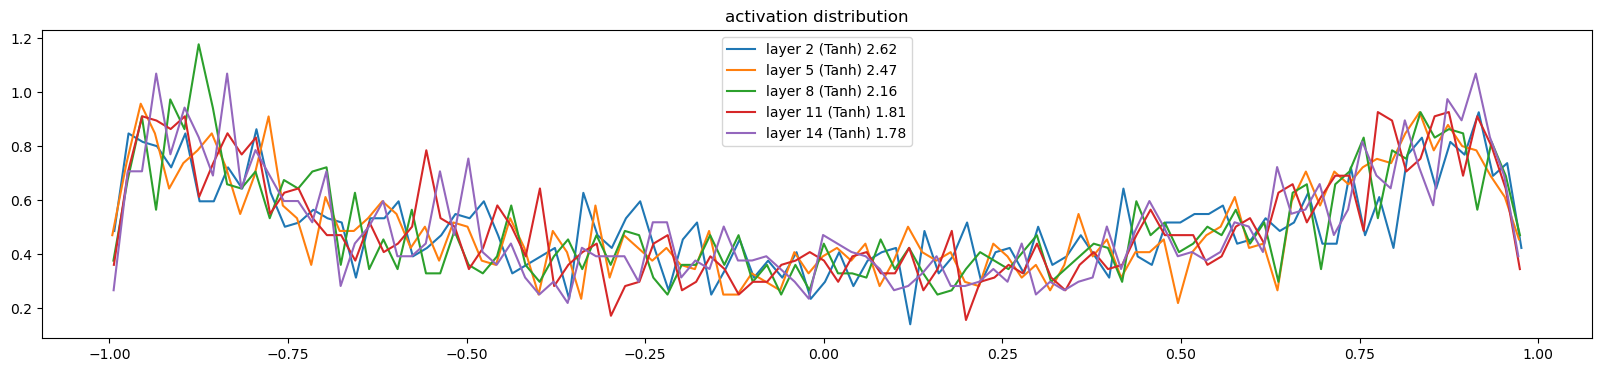

In [473]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the outer layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}) {(t.abs() > 0.97).float().mean()*100:.2f}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.00, std 3.682950e-03
layer 5 (      Tanh): mean -0.00, std 3.262606e-03
layer 8 (      Tanh): mean -0.00, std 2.973729e-03
layer 11 (      Tanh): mean +0.00, std 2.741107e-03
layer 14 (      Tanh): mean -0.00, std 2.584293e-03


Text(0.5, 1.0, 'gradient distribution')

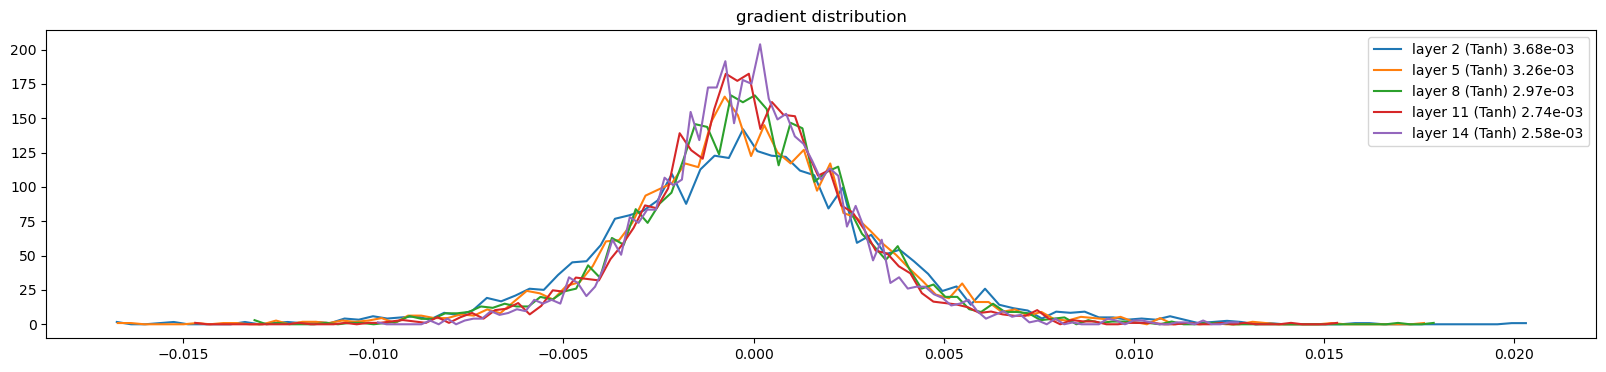

In [474]:
# visualize histograms
plt.figure(figsize=(20, 4))             # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the outer layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}) {t.std():.2e}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.019883e-02 | grad:data ratio 1.018844e-02
weight  (30, 100) | mean +0.000092 | std 8.238419e-03 | grad:data ratio 2.635835e-02
weight (100, 100) | mean +0.000031 | std 7.318100e-03 | grad:data ratio 4.377137e-02
weight (100, 100) | mean -0.000019 | std 6.662020e-03 | grad:data ratio 3.949894e-02
weight (100, 100) | mean -0.000019 | std 5.821514e-03 | grad:data ratio 3.468160e-02
weight (100, 100) | mean +0.000053 | std 5.445292e-03 | grad:data ratio 3.243364e-02
weight  (100, 27) | mean -0.000165 | std 1.046843e-02 | grad:data ratio 6.281257e-02


Text(0.5, 1.0, 'weights gradient distribution')

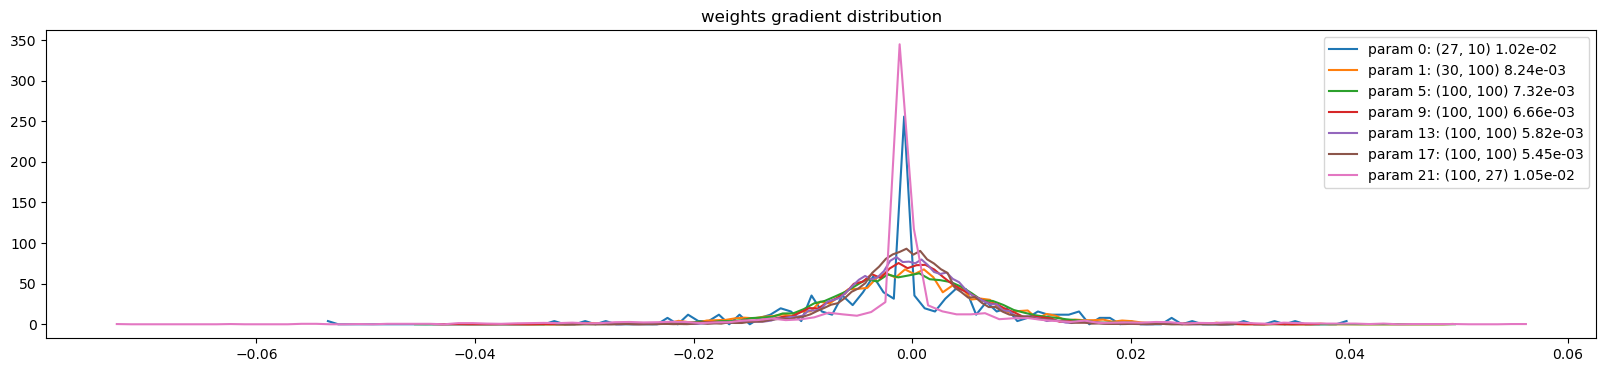

In [475]:
# visualize histograms
plt.figure(figsize=(20, 4))              # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std(),))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'param {i}: {tuple(p.shape)} {t.std():.2e}')
plt.legend(legends);
plt.title('weights gradient distribution')

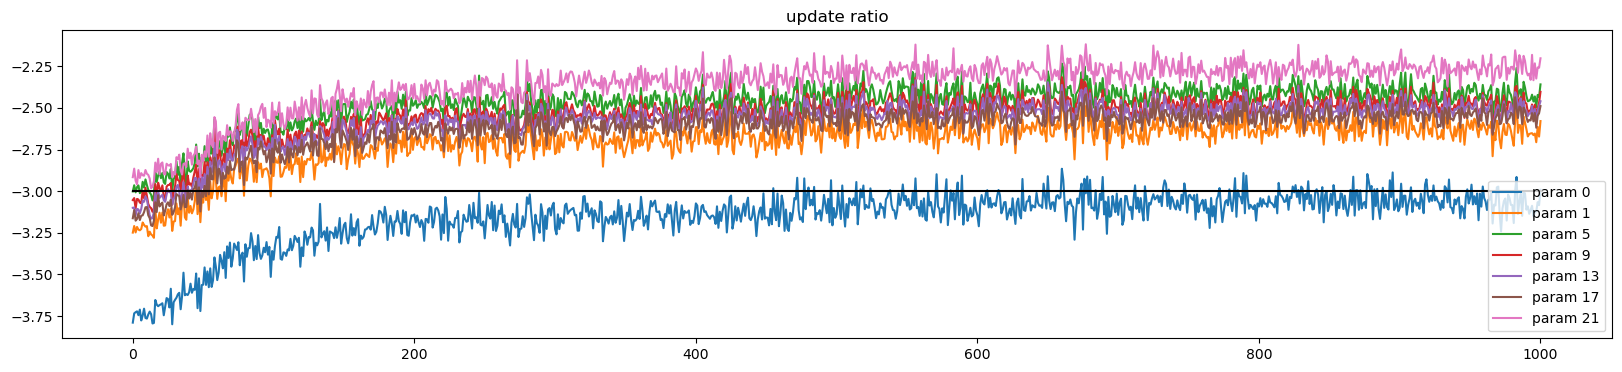

In [476]:
# visualize histograms
plt.figure(figsize=(20, 4))              # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2: # only weights
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # ratios should be ~1e-3, indicate on plot
plt.title('update ratio')
plt.legend(legends);